## 03 비용 최소화하기 - 경사 하강법(Gradient Descent) 소개

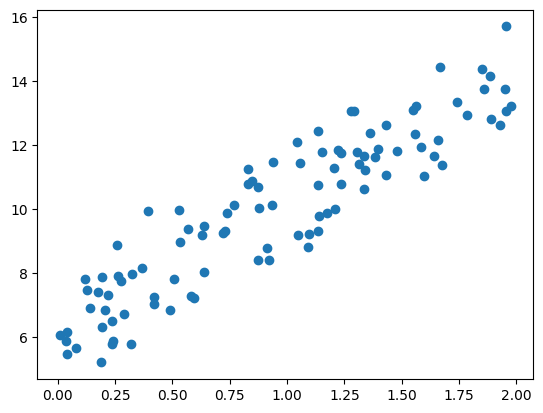

In [258]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
X = 2 * np.random.rand(100, 1)
y = 6 + 4 * X + np.random.randn(100, 1)

plt.scatter(X, y)

In [259]:
def get_cost(y, y_pred):
    N = len(y)
    cost = np.sum(np.square(y - y_pred)) / N
    return cost

In [260]:
def get_weight_updates(w1, w0, X, y, learning_rate=0.01):
    N = len(y)
    w1_update = np.zeros_like(w1)
    w0_update = np.zeros_like(w0)
    y_pred = np.dot(X, w1.T) + w0
    diff = y - y_pred
    
    w0_factors = np.ones((N, 1))
    w1_update = -(2 / N) * learning_rate * (np.dot(X.T, diff))
    w0_update = -(2 / N) * learning_rate * (np.dot(w0_factors.T, diff))
    
    return w1_update, w0_update

In [261]:
def gradient_descent_steps(X, y, iters=10000):
    w0 = np.zeros((1, 1))
    w1 = np.zeros((1, 1))
    
    for ind in range(iters):
        w1_update, w0_update = get_weight_updates(w1, w0, X, y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
    
    return w1, w0

In [262]:
def get_cost(y, y_pred):
    N = len(y)
    cost = np.sum(np.square(y - y_pred)) / N
    return cost

w1, w0 = gradient_descent_steps(X, y, iters=1000)
print('w1:{0:.3f} w0:{1:.3f}'.format(w1[0, 0], w0[0, 0]))
y_pred = w1[0, 0] * X + w0
print('Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1:4.022 w0:6.162
Gradient Descent Total Cost:0.9935


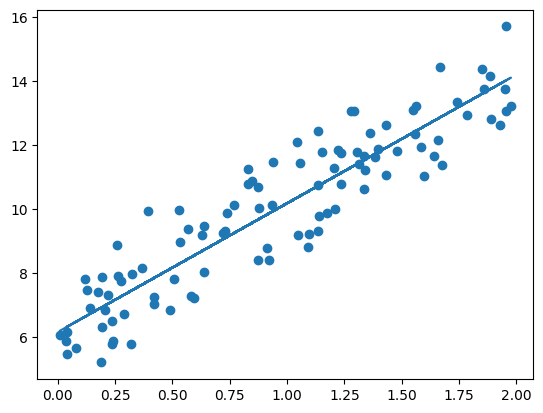

In [263]:
plt.scatter(X, y)
plt.plot(X, y_pred)

In [264]:
def stochastic_gradient_descent_steps(X, y, batch_size=10, iters=1000):
    w0 = np.zeros((1, 1))
    w1 = np.zeros((1, 1))
    
    prev_cost = 100000
    iter_index = 0
    
    for ind in range(iters):
        np.random.seed(ind)
        stochastic_random_index = np.random.permutation(X.shape[0])
        sample_X = X[stochastic_random_index[0:batch_size]]
        sample_y = y[stochastic_random_index[0:batch_size]]
        w1_update, w0_update = get_weight_updates(w1, w0, sample_X, sample_y, learning_rate=0.01)
        w1 = w1 - w1_update
        w0 = w0 - w0_update
    
    return w1, w0

In [265]:
w1, w0 = stochastic_gradient_descent_steps(X, y, iters=1000)
print('w1:', round(w1[0, 0], 3), 'w0:', round(w0[0, 0], 3))
y_pred = w1[0, 0] * X + w0
print('Stochastic Gradient Descent Total Cost:{0:.4f}'.format(get_cost(y, y_pred)))

w1: 4.028 w0: 6.156
Stochastic Gradient Descent Total Cost:0.9937


## 04 사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

#### LinearRegression 클래스 - Ordinary Least Squares

In [266]:
# class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

#### 회기 평가 지표
#### LinearRegression을 이용해 보스턴 주택 가격 회귀 구현

In [267]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

bostonDF = pd.read_csv('boston_house_prices.csv', header=1)
bostonDF.rename(columns={'MEDV': 'PRICE'}, inplace=True)
print('Boston 데이터 세트 크기 :', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [268]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


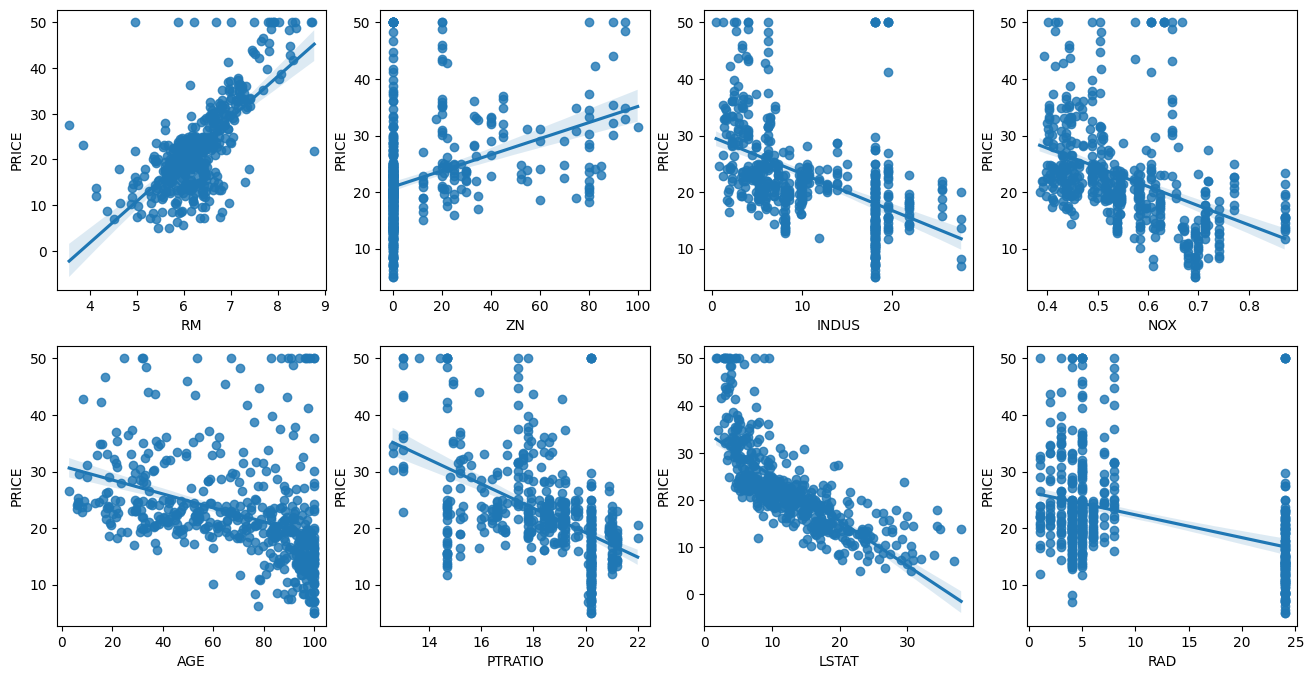

In [269]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
    row = int(i / 4)
    col = i % 4
    sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

In [270]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(
      X_data
    , y_target
    , test_size=0.3
    , random_state=156
)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse, rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [271]:
print('절편 값:', lr.intercept_)
print('회귀 계수값:', np.round(lr.coef_, 1))

절편 값: 40.99559517216436
회귀 계수값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [272]:
coeff = pd.Series(data=np.round(lr.coef_, 1), index=X_data.columns)
coeff.sort_values(ascending=False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
B           0.0
TAX        -0.0
AGE         0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

In [273]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)
lr = LinearRegression()

neg_mse_scores = cross_val_score(
      lr
    , X_data
    , y_target
    , scoring='neg_mean_squared_error'
    , cv=5
)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds 의 개별 Negative MSE scores:', np.round(neg_mse_scores, 2))
print('5 folds 의 개별 RMSE scores :', np.round(rmse_scores, 2))
print('5 folds 의 평균 RMSE : {0:.3f}'.format(avg_rmse))

5 folds 의 개별 Negative MSE scores: [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds 의 개별 RMSE scores : [3.53 5.1  5.75 8.99 5.77]
5 folds 의 평균 RMSE : 5.829


## 05 다항 회귀와 과(대)적합/과소적합 이해
#### 다항 회귀 이해

In [274]:
from sklearn.preprocessing import PolynomialFeatures
import numpy as np

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 피처:\n', X)

poly = PolynomialFeatures(degree=2)
poly.fit(X)
poly_ftr = poly.transform(X)
print('변환된 2차 다항식 계수 피처:\n', poly_ftr)

일차 단항식 계수 피처:
 [[0 1]
 [2 3]]
변환된 2차 다항식 계수 피처:
 [[1. 0. 1. 0. 0. 1.]
 [1. 2. 3. 4. 6. 9.]]


In [275]:
def polynomial_func(X):
    y = 1 + 2 * X[:, 0] + 3 * X[:, 0] ** 2 + 4 * X[:, 1] ** 3
    return y

X = np.arange(4).reshape(2, 2)
print('일차 단항식 계수 feature:\n', X)
y = polynomial_func(X)
print('삼차 다항식 결정값:\n', y)

일차 단항식 계수 feature:
 [[0 1]
 [2 3]]
삼차 다항식 결정값:
 [  5 125]


In [276]:
poly_ftr = PolynomialFeatures(degree=3).fit_transform(X)
print('3차 다항식 계수 feature:\n', poly_ftr)

model = LinearRegression()
model.fit(poly_ftr, y)
print('Polynomial 회귀 계수\n', np.round(model.coef_, 2))
print('Polynomial 회귀 Shape:', model.coef_.shape)

3차 다항식 계수 feature:
 [[ 1.  0.  1.  0.  0.  1.  0.  0.  0.  1.]
 [ 1.  2.  3.  4.  6.  9.  8. 12. 18. 27.]]
Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]
Polynomial 회귀 Shape: (10,)


In [277]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

def polynomial_func(X):
    y = 1 + 2 * X[:, 0] + 3 * X[:, 0] ** 2 + 4 * X[:, 1] ** 3
    return y

model = Pipeline([('poly', PolynomialFeatures(degree=3))
                   , ('linear', LinearRegression())])
X = np.arange(4).reshape(2, 2)
y = polynomial_func(X)

model = model.fit(X, y)

print('Polynomial 회귀 계수\n', np.round(model.named_steps['linear'].coef_, 2))

Polynomial 회귀 계수
 [0.   0.18 0.18 0.36 0.54 0.72 0.72 1.08 1.62 2.34]


#### 다항 회귀를 이용한 과소적합 및 과적합 이해

In [278]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
%matplotlib inline

def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)
n_samples = 30
X = np.sort(np.random.rand(n_samples))

y = true_fun(X) + np.random.randn(n_samples) * 0.1


Degree 1 회귀 계수는 [-1.61] 입니다.
Degree 1 MSE는 0.40772896250986845 입니다.

Degree 4 회귀 계수는 [  0.47 -17.79  23.59  -7.26] 입니다.
Degree 4 MSE는 0.0432087498723184 입니다.

Degree 15 회귀 계수는 [-2.98294000e+03  1.03899850e+05 -1.87416981e+06  2.03717199e+07
 -1.44874017e+08  7.09319141e+08 -2.47067173e+09  6.24564702e+09
 -1.15677216e+10  1.56895933e+10 -1.54007040e+10  1.06457993e+10
 -4.91381016e+09  1.35920643e+09 -1.70382078e+08] 입니다.
Degree 15 MSE는 182581084.8263125 입니다.


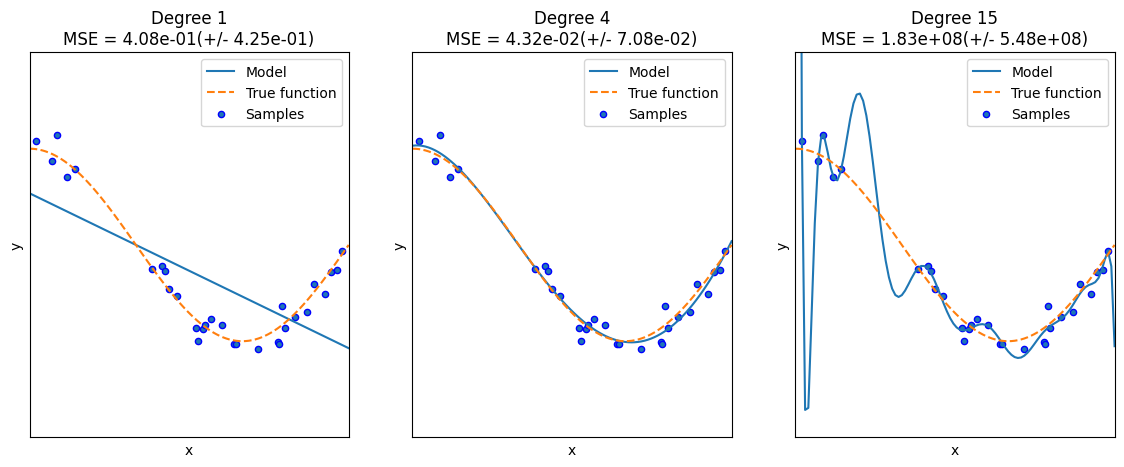

In [279]:
plt.figure(figsize=(14, 5))
degrees = [1, 4, 15]

for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())
    
    polynomial_features = PolynomialFeatures(degree=degrees[i], include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([('polynomial_features', polynomial_features)
                         , ('linear_regression', linear_regression)])
    pipeline.fit(X.reshape(-1, 1), y)
    
    scores = cross_val_score(pipeline, X.reshape(-1, 1), y, scoring='neg_mean_squared_error', cv=10)
    coefficients = pipeline.named_steps['linear_regression'].coef_
    print('\nDegree {0} 회귀 계수는 {1} 입니다.'.format(degrees[i], np.round(coefficients, 2)))
    print('Degree {0} MSE는 {1} 입니다.'.format((degrees[i]), -1 * np.mean(scores)))
    
    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label='Model')
    plt.plot(X_test, true_fun(X_test), '--', label='True function')
    plt.scatter(X, y, edgecolors='b', s=20, label='Samples')
    
    plt.xlabel('x'); plt.ylabel('y'); plt.xlim((0, 1)); plt.ylim((-2, 2)); plt.legend(loc='best')
    plt.title('Degree {}\nMSE = {:.2e}(+/- {:.2e})'.format(degrees[i], -scores.mean(), scores.std()))

plt.show()

#### 편향-분산 트레이드오프(Bias-Variance Trade off)

## 06 규제 선형 모델 - 릿지, 라쏘, 엘라스틱넷
#### 규제 선형 모델의 개요
#### 릿지 회귀

In [280]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

ridge = Ridge(alpha=10)
neg_mse_scores = cross_val_score(
      ridge
    , X_data
    , y_target
    , scoring='neg_mean_squared_error'
    , cv=5
)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores:', np.round(neg_mse_scores, 3))
print('5 folds의 개별 RMSE scores:', np.round(rmse_scores, 3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores: [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores: [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


In [281]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    
    neg_mse_scores = cross_val_score(
          ridge
        , X_data
        , y_target
        , scoring='neg_mean_squared_error'
        , cv=5
    )
    avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
    print('alpha {0} 일 때 5 folds 의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0 일 때 5 folds 의 평균 RMSE : 5.829
alpha 0.1 일 때 5 folds 의 평균 RMSE : 5.788
alpha 1 일 때 5 folds 의 평균 RMSE : 5.653
alpha 10 일 때 5 folds 의 평균 RMSE : 5.518
alpha 100 일 때 5 folds 의 평균 RMSE : 5.330


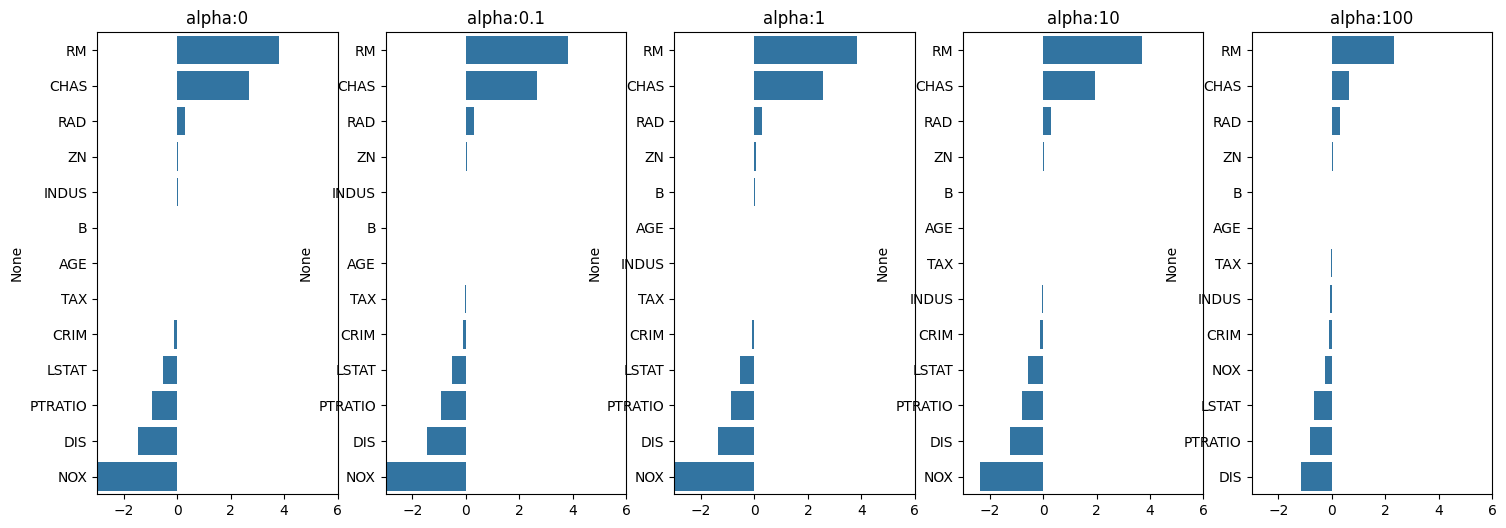

In [282]:
fig, axs = plt.subplots(figsize=(18, 6), nrows=1, ncols=5)
coeff_df = pd.DataFrame()

for pos, alpha in enumerate(alphas):
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_data, y_target)
    coeff = pd.Series(data=ridge.coef_, index=X_data.columns)
    colname = 'alpha:' + str(alpha)
    coeff_df[colname] = coeff
    coeff = coeff.sort_values(ascending=False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3, 6)
    sns.barplot(x=coeff.values, y=coeff.index, ax=axs[pos])

plt.show()

In [283]:
ridge_alphas = [0, 0.1, 1, 10, 100]
sort_column = 'alpha:' + str(ridge_alphas[0])
coeff_df.sort_values(by=sort_column, ascending=False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


#### 라쏘 회귀

In [284]:
from sklearn.linear_model import Lasso, ElasticNet

def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha=param)
        elif model_name == 'Lasso': model = Lasso(alpha=param)
        elif model_name == 'ElasticNet': model = ElasticNet(alpha=param, l1_ratio=0.7)
        neg_mse_scores = cross_val_score(
              model
            , X_data_n
            , y_target_n
            , scoring='neg_mean_squared_error'
            , cv=5
        )
        avg_rmse = np.mean(np.sqrt(-1 * neg_mse_scores))
        print('alpha {0}일 때 5 폴드 세트의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))
        
        model.fit(X_data_n, y_target_n)
        if return_coeff:
            coeff = pd.Series(
                  data=model.coef_
                , index=X_data_n.columns
            )
            colname = 'alpha:' + str(param)
            coeff_df[colname] = coeff
    
    return coeff_df

In [285]:
lasso_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval(
      'Lasso'
    , params=lasso_alphas
    , X_data_n=X_data
    , y_target_n=y_target
)

###### Lasso ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.612
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.615
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.669
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.776
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.189


In [286]:
sort_column = 'alpha:' + str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


#### 엘라스틱넷 회귀

In [287]:
elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval(
      'ElasticNet'
    , params=elastic_alphas
    , X_data_n=X_data
    , y_target_n=y_target
)

###### ElasticNet ######
alpha 0.07일 때 5 폴드 세트의 평균 RMSE: 5.542
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.526
alpha 0.5일 때 5 폴드 세트의 평균 RMSE: 5.467
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.597
alpha 3일 때 5 폴드 세트의 평균 RMSE: 6.068


In [288]:
sort_column = 'alpha:' + str(elastic_alphas[0])
coeff_elastic_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


#### 선형 회귀 모델을 위한 데이터 변환

In [289]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def get_scaled_data(method='None', p_degree=None, input_data=None):
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
    else:
        scaled_data = input_data
    
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, include_bias=False).fit_transform(scaled_data)
    
    return scaled_data

In [290]:
alphas = [0.1, 1, 10, 100]

scale_methods = [
    (None, None), ('Standard', None), ('Standard', 2), ('MinMax', None), ('MinMax', 2), ('Log', None)
]
for scale_method in scale_methods:
    X_data_scaled = get_scaled_data(
          method=scale_method[0]
        , p_degree=scale_method[1]
        , input_data=X_data
    )
    print('\n## 변환 유형:{0}, Polynomial Degree:{1}'.format(scale_method[0], scale_method[1]))
    get_linear_reg_eval(
        'Ridge'
        , params=alphas
        , X_data_n=X_data_scaled
        , y_target_n=y_target
        , verbose=False
        , return_coeff=False
    )


## 변환 유형:None, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.788
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.653
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.518
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.330

## 변환 유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.826
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.803
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.637
alpha 100일 때 5 폴드 세트의 평균 RMSE: 5.421

## 변환 유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 8.827
alpha 1일 때 5 폴드 세트의 평균 RMSE: 6.871
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.485
alpha 100일 때 5 폴드 세트의 평균 RMSE: 4.634

## 변환 유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.764
alpha 1일 때 5 폴드 세트의 평균 RMSE: 5.465
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.754
alpha 100일 때 5 폴드 세트의 평균 RMSE: 7.635

## 변환 유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 5.298
alpha 1일 때 5 폴드 세트의 평균 RMSE: 4.323
alpha 10일 때 5 폴드 세트의 평균 RMSE: 5.185
alpha 100일 때 5 폴드 세트의 평균 RMSE: 6.538

## 변환 유형:Log, Polynomial Degree:None
alpha 0.1일 때 5 폴드 세트의 평균 RMSE: 4.770

## 07 로지스틱 회귀

In [291]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

cancer = load_breast_cancer()

In [292]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
data_scaled = scaler.fit_transform(cancer.data)

X_train, X_test, y_train, y_test = train_test_split(
      data_scaled
    , cancer.target
    , test_size=0.3
    , random_state=0
)

In [293]:
from sklearn.metrics import accuracy_score, roc_auc_score

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_preds = lr_clf.predict(X_test)

print(f'accuracy: {accuracy_score(y_test, lr_preds):.3f}, roc_auc: {roc_auc_score(y_test, lr_preds):.3f}')

accuracy: 0.977, roc_auc: 0.972


In [294]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']

for solver in solvers:
    lr_clf = LogisticRegression(solver=solver, max_iter=600)
    lr_clf.fit(X_train, y_train)
    lr_preds = lr_clf.predict(X_test)
    
    print(f'solver: {solver}, accuracy: {accuracy_score(y_test, lr_preds):.3f}, roc_auc: {roc_auc_score(y_test, lr_preds):.3f}')

solver: lbfgs, accuracy: 0.977, roc_auc: 0.972
solver: liblinear, accuracy: 0.982, roc_auc: 0.979
solver: newton-cg, accuracy: 0.977, roc_auc: 0.972
solver: sag, accuracy: 0.982, roc_auc: 0.979
solver: saga, accuracy: 0.982, roc_auc: 0.979


In [295]:
from sklearn.model_selection import GridSearchCV

params = {
      'solver': ['liblinear', 'lbfgs']
    , 'penalty': ['l2', 'l1']
    , 'C': [0.01, 0.1, 1, 1, 5, 10]
}

lr_clf = LogisticRegression()

grid_clf = GridSearchCV(lr_clf, param_grid=params, scoring='accuracy', cv=3)
grid_clf.fit(data_scaled, cancer.target)
print(f'최적 하이퍼 파라미터: {grid_clf.best_params_}, 최적 평균 정확도: {grid_clf.best_score_:.3f}')

최적 하이퍼 파라미터: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 최적 평균 정확도: 0.979


## 08 회귀 트리

In [296]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

bostonDF = pd.read_csv('./boston_house_prices.csv', header=1)

bostonDF.rename(columns={'MEDV': 'PRICE'}, inplace=True)
y_target = bostonDF['PRICE']
X_data = bostonDF.drop('PRICE', axis=1, inplace=False)

rf = RandomForestRegressor(random_state=0, n_estimators=1000)
neg_mse_scores = cross_val_score(
    rf,
    X_data,
    y_target,
    scoring='neg_mean_squared_error',
    cv=5,
)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print(f'5 교차 검증의 개별 Negative MSE scores: {np.round(neg_mse_scores, 2)}')
print(f'5 교차 검증의 개별 RMSE scores : {np.round(rmse_scores, 2)}')
print(f'5 교차 검증의 평균 RMSE : {avg_rmse:.3f}')

5 교차 검증의 개별 Negative MSE scores: [ -7.88 -13.14 -20.57 -46.23 -18.88]
5 교차 검증의 개별 RMSE scores : [2.81 3.63 4.54 6.8  4.34]
5 교차 검증의 평균 RMSE : 4.423


In [297]:
def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(
        model,
        X_data,
        y_target,
        scoring='neg_mean_squared_error',
        cv=5
    )
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print(f'#####  {model.__class__.__name__}  #####')
    print(f'5 교차 검증의 평균 RMSE : {avg_rmse:.3f}')

In [298]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

dt_reg = DecisionTreeRegressor(random_state=0, max_depth=4)
rf_reg = RandomForestRegressor(random_state=0, n_estimators=1000)
gb_reg = GradientBoostingRegressor(random_state=0, n_estimators=1000)
xgb_reg = XGBRegressor(n_estimators=1000)
lgb_reg = LGBMRegressor(n_estimators=1000)

models = [dt_reg, rf_reg, gb_reg, xgb_reg, lgb_reg]
for model in models:
    get_model_cv_prediction(model, X_data, y_target)

#####  DecisionTreeRegressor  #####
5 교차 검증의 평균 RMSE : 5.978
#####  RandomForestRegressor  #####
5 교차 검증의 평균 RMSE : 4.423
#####  GradientBoostingRegressor  #####
5 교차 검증의 평균 RMSE : 4.269
#####  XGBRegressor  #####
5 교차 검증의 평균 RMSE : 4.959
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 996
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 13
[LightGBM] [Info] Start training from score 22.566089
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

<Axes: xlabel='None', ylabel='None'>

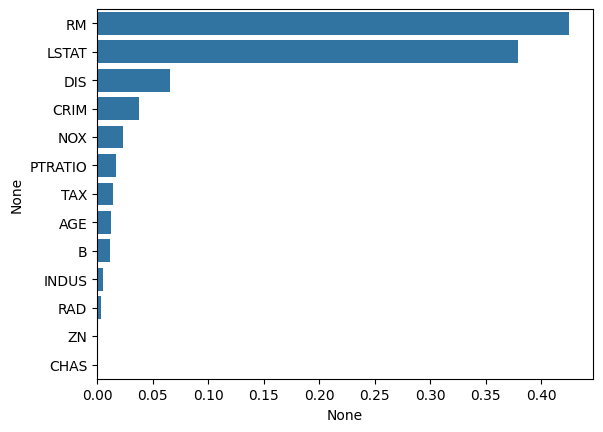

In [299]:
import seaborn as sns
%matplotlib inline

rf_reg = RandomForestRegressor(n_estimators=1000)

rf_reg.fit(X_data, y_target)

feature_series = pd.Series(data=rf_reg.feature_importances_, index=X_data.columns)
feature_series = feature_series.sort_values(ascending=False)
sns.barplot(x=feature_series, y=feature_series.index)

(100, 2)


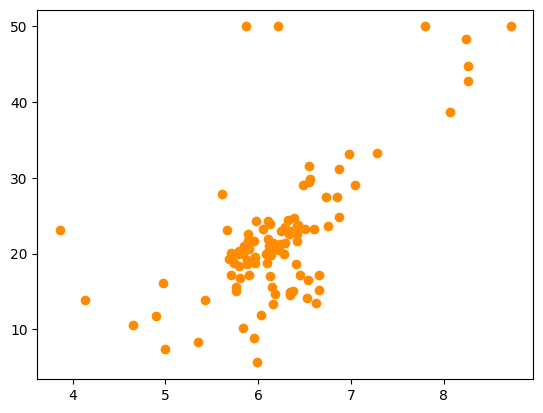

In [300]:
bostonDF_sample = bostonDF[['RM', 'PRICE']]
bostonDF_sample = bostonDF_sample.sample(n=100, random_state=0)
print(bostonDF_sample.shape)
plt.figure()
plt.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')

In [301]:
import numpy as np
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()
rf_reg2 = DecisionTreeRegressor(max_depth=2)
rf_reg7 = DecisionTreeRegressor(max_depth=7)

X_test = np.arange(4.5, 8.5, 0.04).reshape(-1, 1)

X_feature = bostonDF_sample['RM'].values.reshape(-1, 1)
y_target = bostonDF_sample['PRICE'].values.reshape(-1, 1)

lr_reg.fit(X_feature, y_target)
rf_reg2.fit(X_feature, y_target)
rf_reg7.fit(X_feature, y_target)

pred_lr = lr_reg.predict(X_test)
pred_rf2 = rf_reg2.predict(X_test)
pred_rf7 = rf_reg7.predict(X_test)

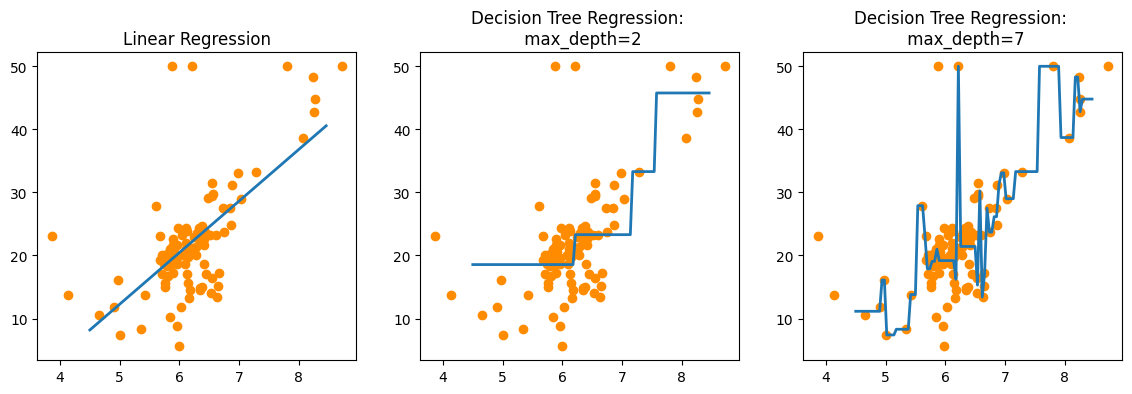

In [302]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 4), ncols=3)

ax1.set_title('Linear Regression')
ax1.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax1.plot(X_test, pred_lr, label='linear', linewidth=2)

ax2.set_title('Decision Tree Regression: \n max_depth=2')
ax2.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax2.plot(X_test, pred_rf2, label='max_depth:2', linewidth=2)

ax3.set_title('Decision Tree Regression: \n max_depth=7')
ax3.scatter(bostonDF_sample.RM, bostonDF_sample.PRICE, c='darkorange')
ax3.plot(X_test, pred_rf7, label='max_depth:7', linewidth=2)

## 09 회귀 실습 - 자전거 대여 수요 예측
#### 데이터 클렌징 및 가공화 데이터 시각화

In [303]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

bike_df = pd.read_csv('./bike_train.csv')
print(bike_df.shape)
bike_df.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [304]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [305]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)

bike_df['year'] = bike_df.datetime.apply(lambda x: x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x: x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x: x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x: x.hour)
bike_df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [306]:
drop_columns = ['datetime', 'casual', 'registered']
bike_df.drop(drop_columns, axis=1, inplace=True)

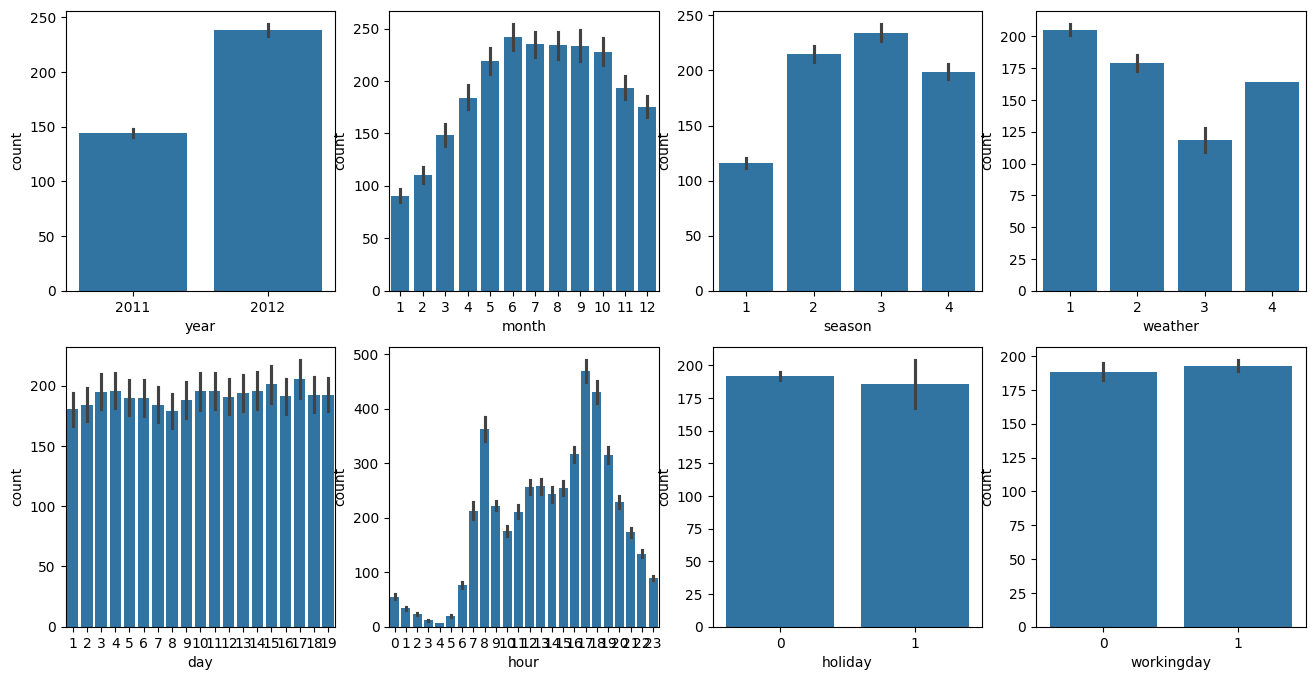

In [307]:
fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)
cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
for i, feature in enumerate(cat_features):
    row = int(i / 4)
    col = i % 4
    sns.barplot(x=feature, y='count', data=bike_df, ax=axs[row][col])

In [308]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

def rmse(y, pred):
    return np.sqrt(mean_squared_error(y, pred))

def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    mae_val = mean_absolute_error(y, pred)
    print(f'RMSLE: {rmsle_val:.3f}, RMSE: {rmse_val:.3f}, MAE: {mae_val:.3f}')

In [309]:
# def rmsle(y, pred):
#     msle = mean_squared_log_error(y, pred)
#     rmsle = np.sqrt(msle)
#     return rmsle

#### 로그 변환, 피처 인코딩과 모델 학습/예측/평가

In [310]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

y_target = bike_df['count']
X_features = bike_df.drop(['count'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

evaluate_regr(y_test, pred)

RMSLE: 1.165, RMSE: 140.900, MAE: 105.924


In [311]:
def get_top_error_data(y_test, pred, n_tops=5):
    result_df = pd.DataFrame(y_test.values, columns=['real_count'])
    result_df['predicted_count'] = np.round(pred)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])

get_top_error_data(y_test, pred)

      real_count  predicted_count   diff
1618         890            322.0  568.0
966          884            327.0  557.0
3151         798            241.0  557.0
412          745            194.0  551.0
2817         856            310.0  546.0


<Axes: >

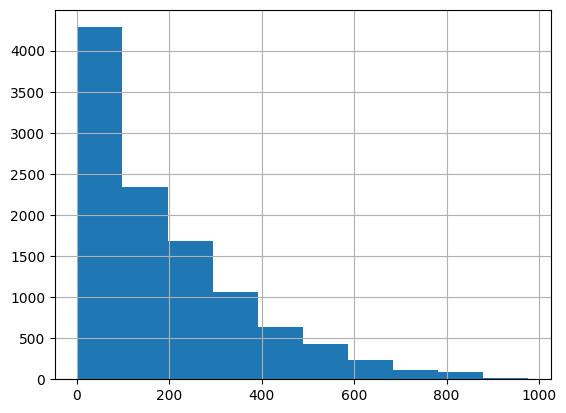

In [312]:
y_target.hist()

<Axes: >

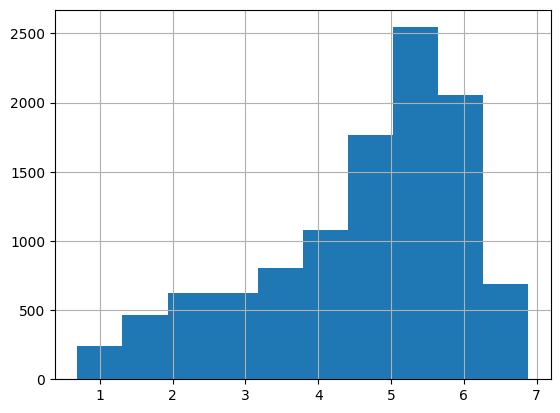

In [313]:
y_log_transform = np.log1p(y_target)
y_log_transform.hist()

In [314]:
y_target_log = np.log1p(y_target)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target_log, test_size=0.3, random_state=0)

lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
pred = lr_reg.predict(X_test)

y_test_exp = np.expm1(y_test)

pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp, pred_exp)

RMSLE: 1.017, RMSE: 162.594, MAE: 109.286


<Axes: ylabel='None'>

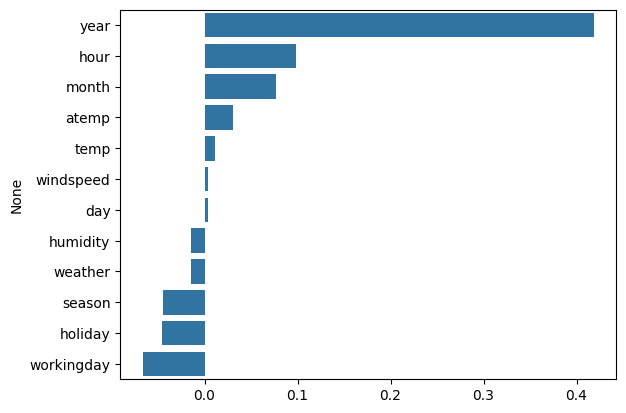

In [315]:
coef = pd.Series(lr_reg.coef_, index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [316]:
X_features_ohe = pd.get_dummies(X_features, columns=['year', 'month', 'day', 'hour', 'holiday', 'workingday', 'season', 'weather'])

In [317]:
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log, test_size=0.3, random_state=0)

def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1:
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print(f'### {model.__class__.__name__} ###')
    evaluate_regr(y_test, pred)

lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=True)

### LinearRegression ###
RMSLE: 0.590, RMSE: 97.688, MAE: 63.382
### Ridge ###
RMSLE: 0.590, RMSE: 98.529, MAE: 63.893
### Lasso ###
RMSLE: 0.635, RMSE: 113.219, MAE: 72.803


<Axes: ylabel='None'>

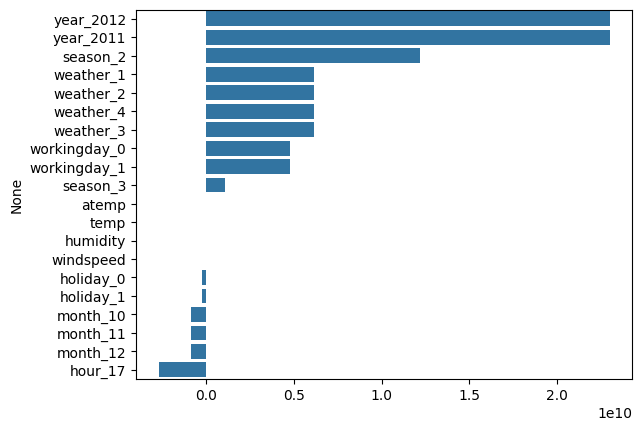

In [318]:
coef = pd.Series(lr_reg.coef_, index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values, y=coef_sort.index)

In [319]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, X_train.values, X_test.values, y_train.values, y_test.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.355, RMSE: 50.377, MAE: 31.238
### GradientBoostingRegressor ###
RMSLE: 0.330, RMSE: 53.322, MAE: 32.734
### XGBRegressor ###
RMSLE: 0.339, RMSE: 51.475, MAE: 31.357
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 348
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.582043
### LGBMRegressor ###
RMSLE: 0.319, RMSE: 47.215, MAE: 29.029


## 회귀 실습 - 캐글 주택 가격: 고급 회귀 기법
#### 데이터 사전 처리(Preprocessing)

In [320]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [321]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 피처의 type \n', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 칼럼과 그 건수:\n', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 칼럼과 그 건수:
 PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
dtype: int64


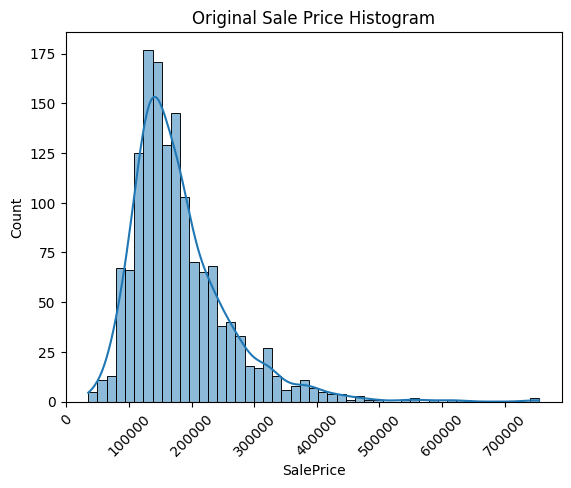

In [322]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

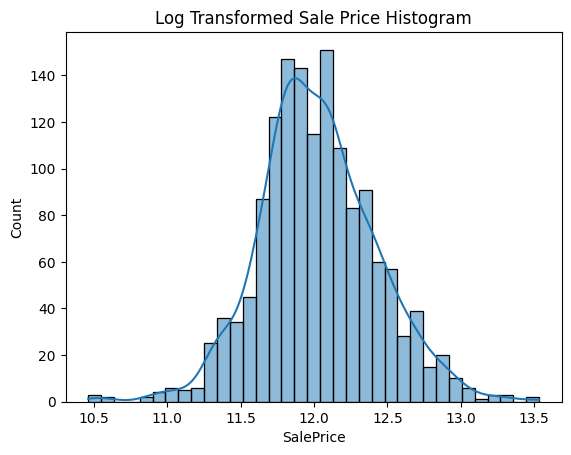

In [323]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [324]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])
# Null이 너무 많은 칼럼과 불필요한 칼럼 삭제
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)
# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
# object 타입이 아닌 인덱스(컬럼명) 추출 => 리스트
number_columns = house_df.dtypes[house_df.dtypes != 'object'].index.to_list()
house_df[number_columns] = house_df[number_columns].fillna(house_df[number_columns].mean(),inplace=False) # house_df.mean() 컬럼별 평균

# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [325]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1460, 75)
get_dummies() 수행 후 데이터 Shape: (1460, 270)
## Null 피처의 Type :
 Series([], dtype: object)


#### 선형 회귀 모델 학습/예측/평가

In [326]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(f'{model.__class__.__name__} 로그 변환된 RMSE: {np.round(rmse, 3)}')
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [327]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_target,
    test_size=0.2,
    random_state=156,
)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.298
Ridge 로그 변환된 RMSE: 0.296
Lasso 로그 변환된 RMSE: 0.353


[np.float64(0.29822343670049717),
 np.float64(0.2960325867595721),
 np.float64(0.35282278272105405)]

In [328]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 칼럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개의 회귀 계수를 추출해 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

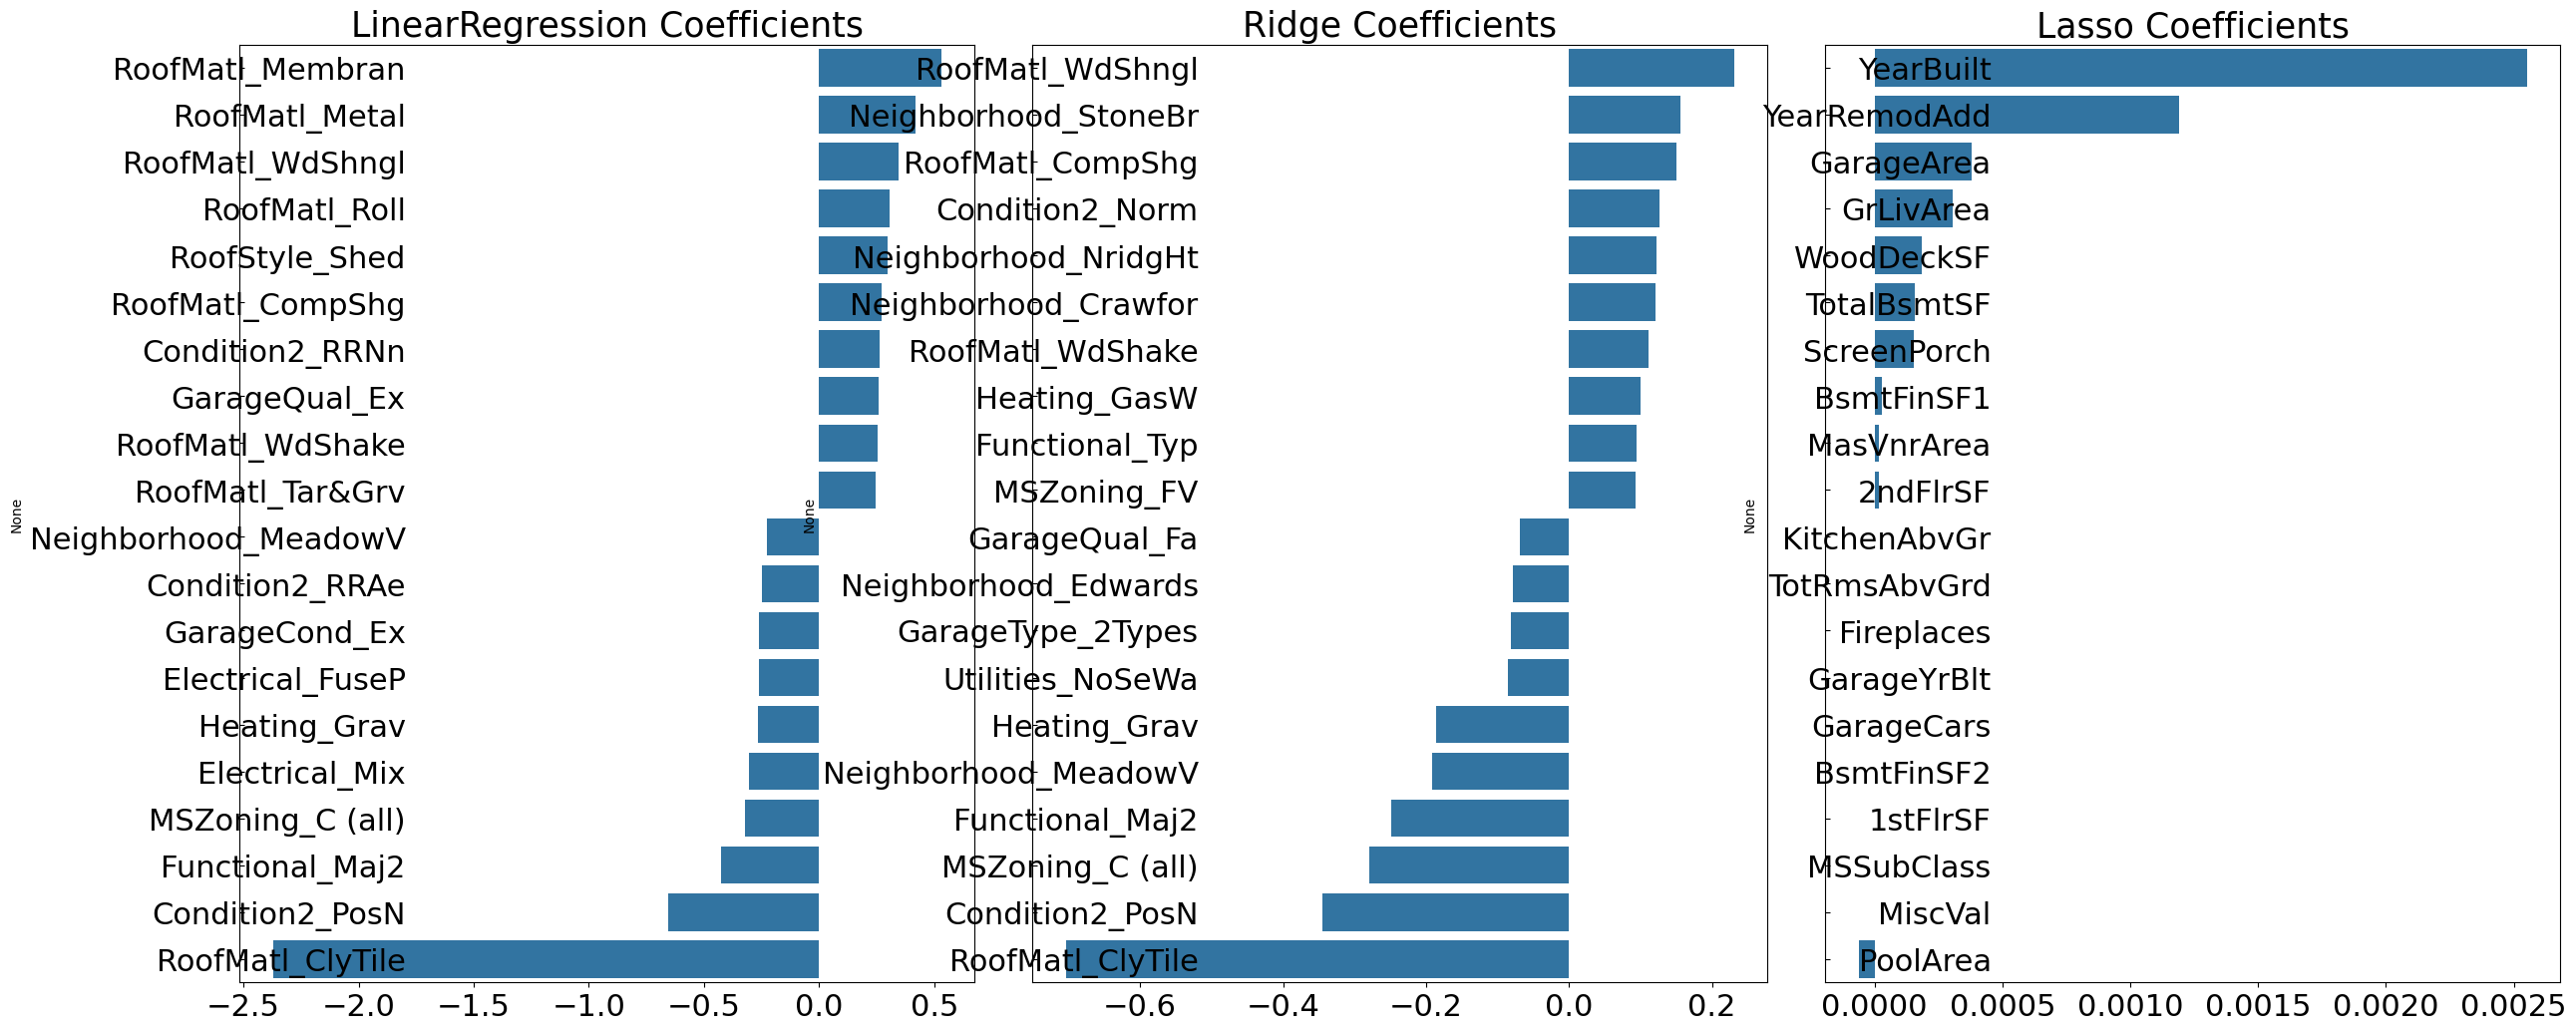

In [329]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 칼럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    # 입력 인자로 받은 list 객체인 models에서 차례로 model을 추출해 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        # ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(f'{model.__class__.__name__} Coefficients', size=25)
        axs[i_num].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [330]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target, scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print(f'\n{model.__class__.__name__} CV RMSE 값 리스트: {np.round(rmse_list, 3)}')
        print(f'{model.__class__.__name__} CV 평균 RMSE 값: {np.round(rmse_avg, 3)}')

# 앞 예제에서 학습한 ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


In [331]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print(f'{model.__class__.__name__} 5 CV 시 최적 평균 RMSE 값:{np.round(rmse, 4)}, 최적 alpha:{grid_model.best_params_}')
    return grid_model.best_estimator_

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.298
Ridge 로그 변환된 RMSE: 0.294
Lasso 로그 변환된 RMSE: 0.292


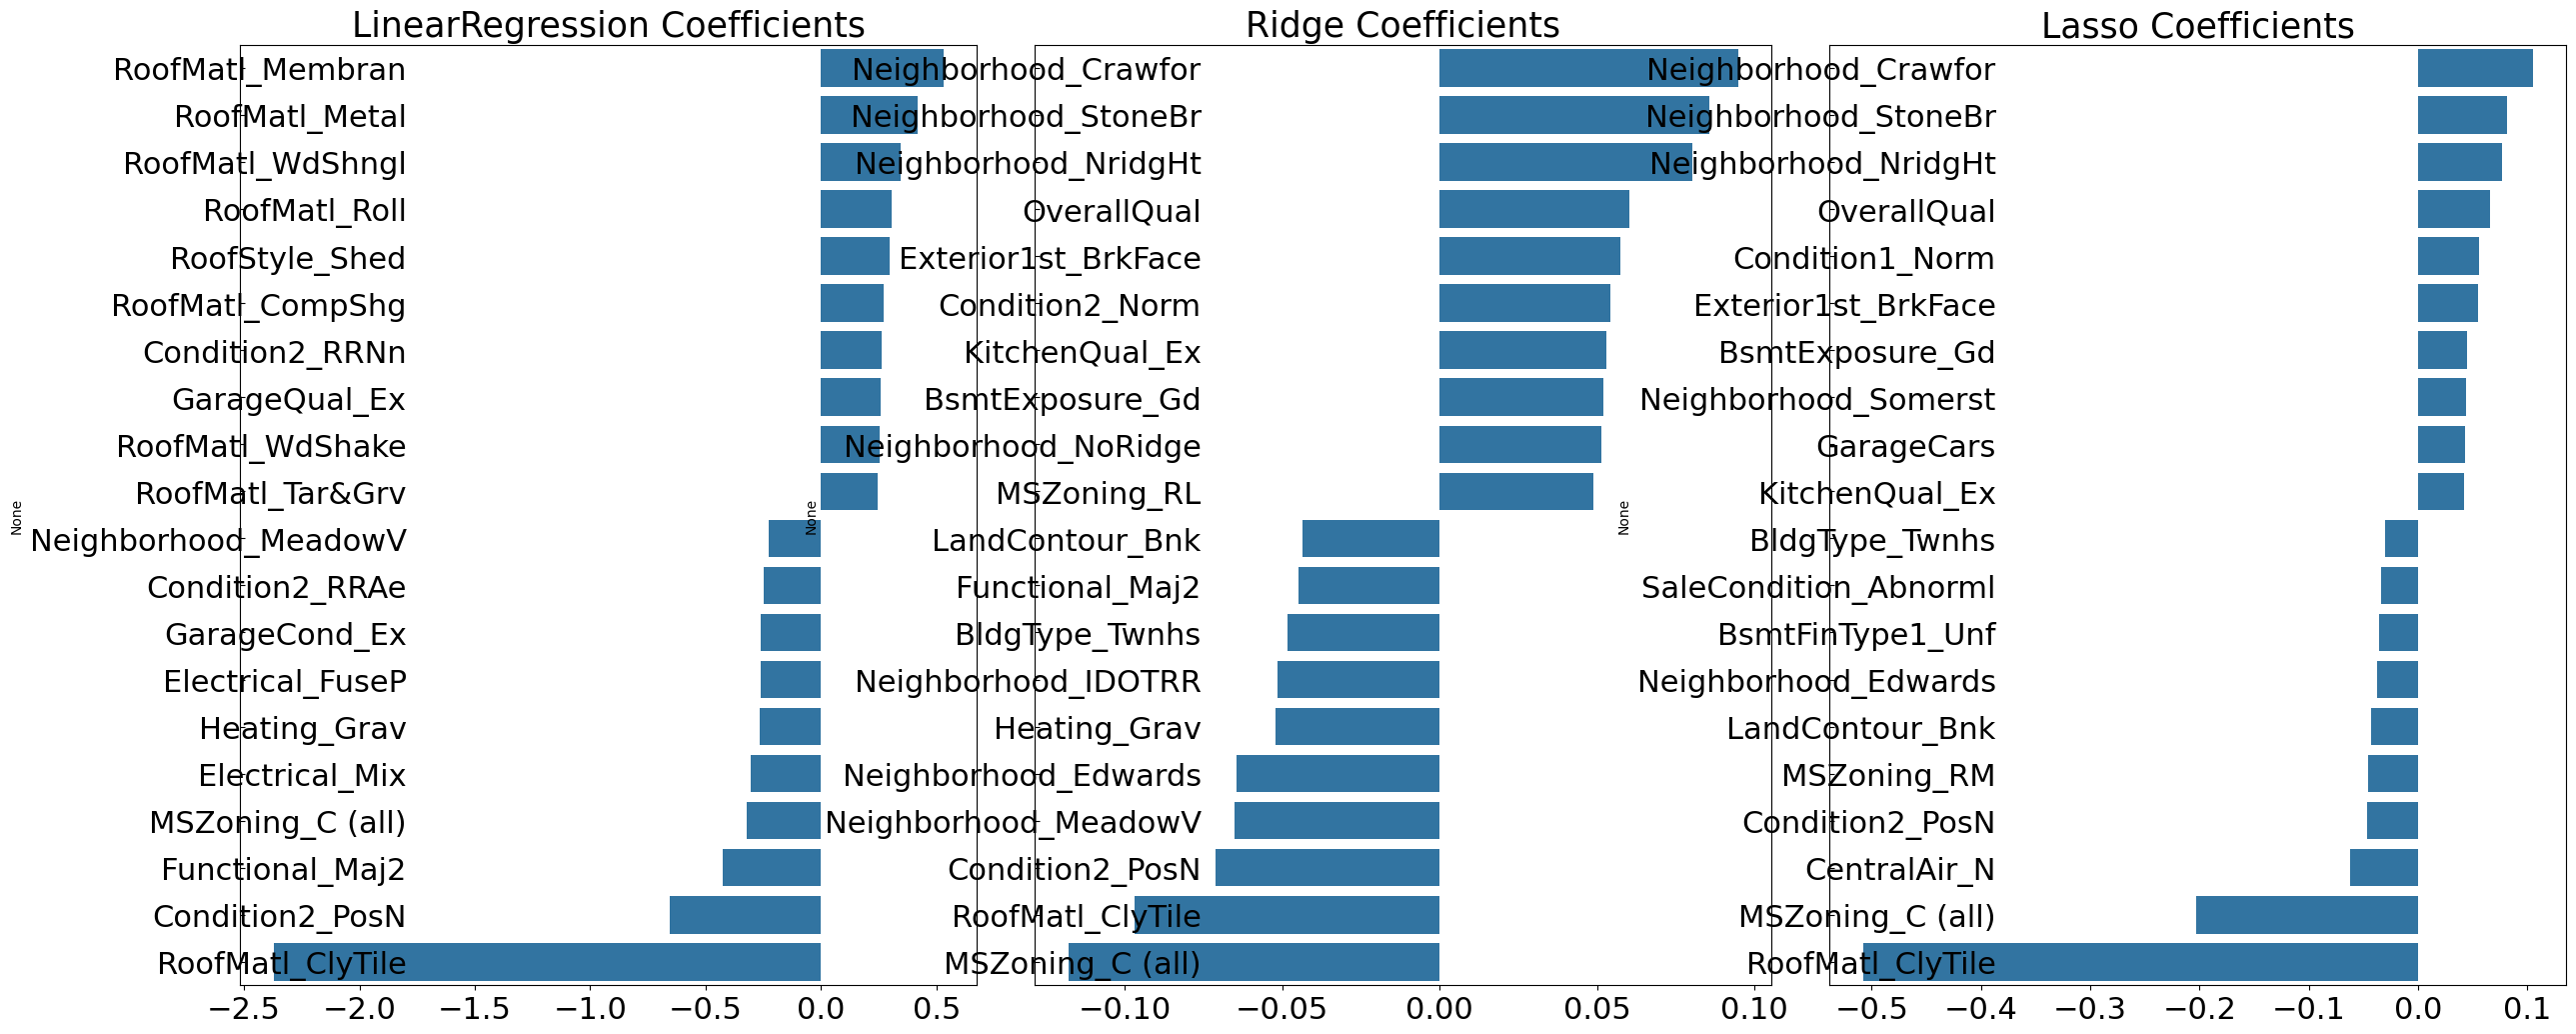

In [332]:
# 앞의 최적화 alpha 값으로 데이터 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

In [333]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 []로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew() 호출
skew_features = house_df[features_index].apply(lambda x: skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [334]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [335]:
# 왜곡 정도가 높은 피처를 로그 반환했으므로 다시 원-핫 인코딩을 적용하고 피처/타깃 데이터 세트 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_target,
    test_size=0.2,
    random_state=156,
)

# 피처를 로그 변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.294
Ridge 로그 변환된 RMSE: 0.289
Lasso 로그 변환된 RMSE: 0.285


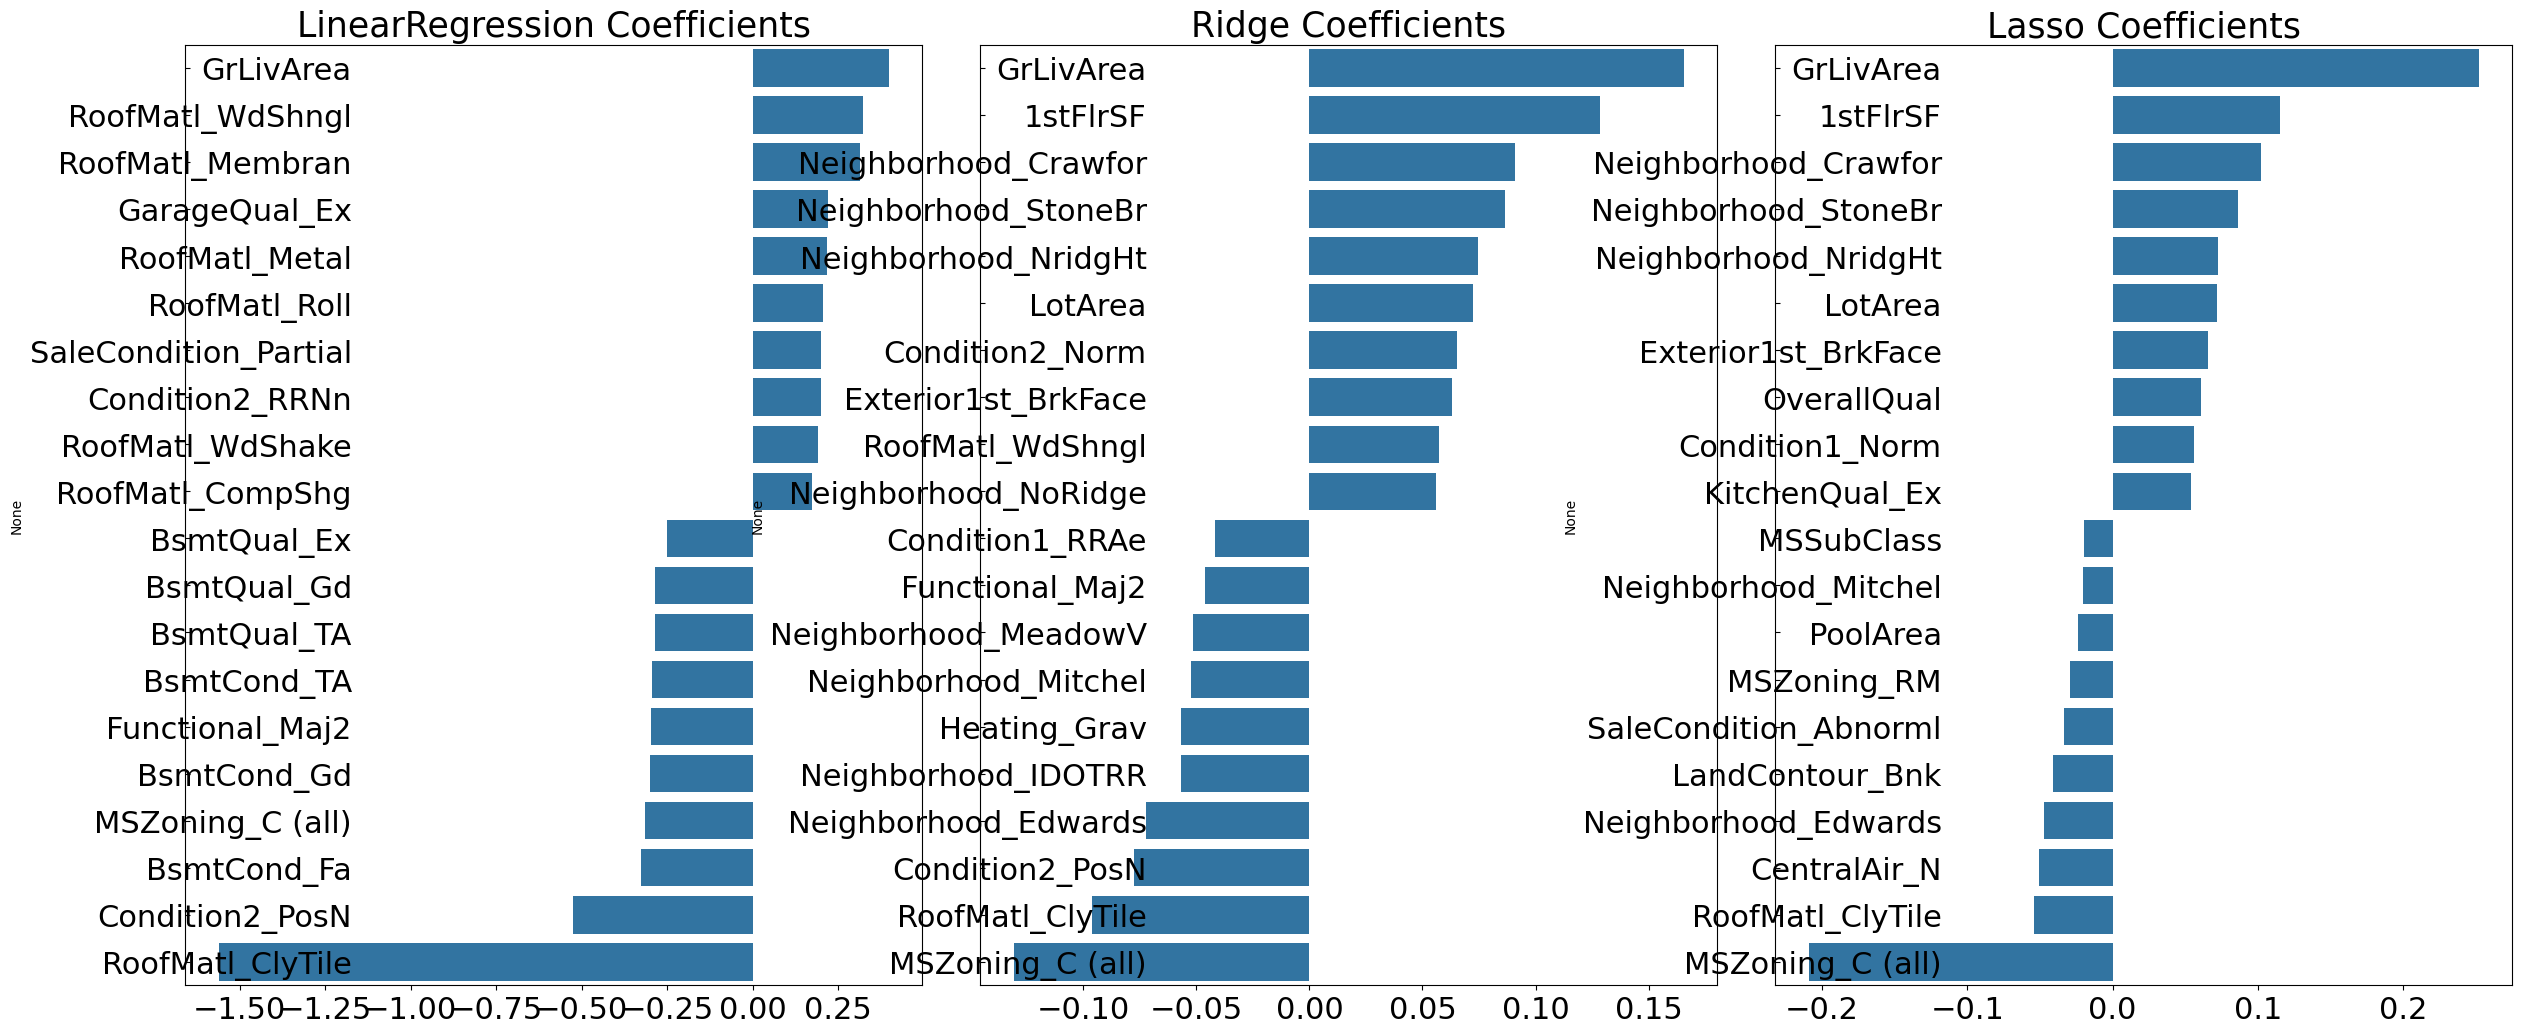

In [336]:
# 앞의 최적화 alpha 값으로 데이터 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

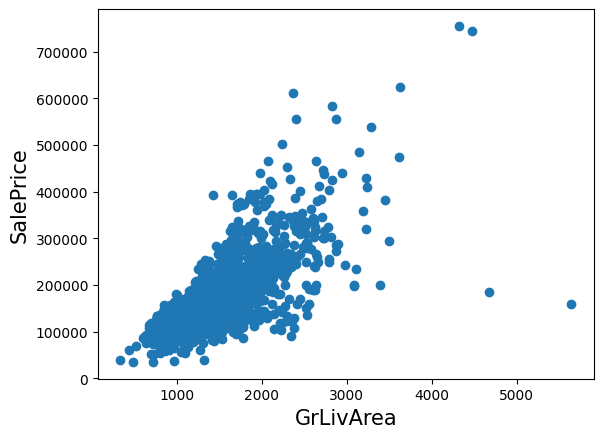

In [337]:
plt.scatter(x=house_df_org['GrLivArea'], y=house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [338]:
# GrLiveArea와 SalePrice 모두 로그 변환됐으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('이상치 레코드 index :', outlier_index.values)
print('이상치 삭제 전 house_df_ohe shape:', house_df_ohe.shape)

# DataFrame의 인덱스를 이용해 이상치 레코드 삭제.
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print('이상치 삭제 후 house_df_ohe.shape:', house_df_ohe.shape)

이상치 레코드 index : [ 523 1298]
이상치 삭제 전 house_df_ohe shape: (1460, 270)
이상치 삭제 후 house_df_ohe.shape: (1458, 270)


In [339]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_target,
    test_size=0.2,
    random_state=156,
)

ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}
print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


Lasso(alpha=0.001)

LinearRegression 로그 변환된 RMSE: 0.298
Ridge 로그 변환된 RMSE: 0.27
Lasso 로그 변환된 RMSE: 0.266


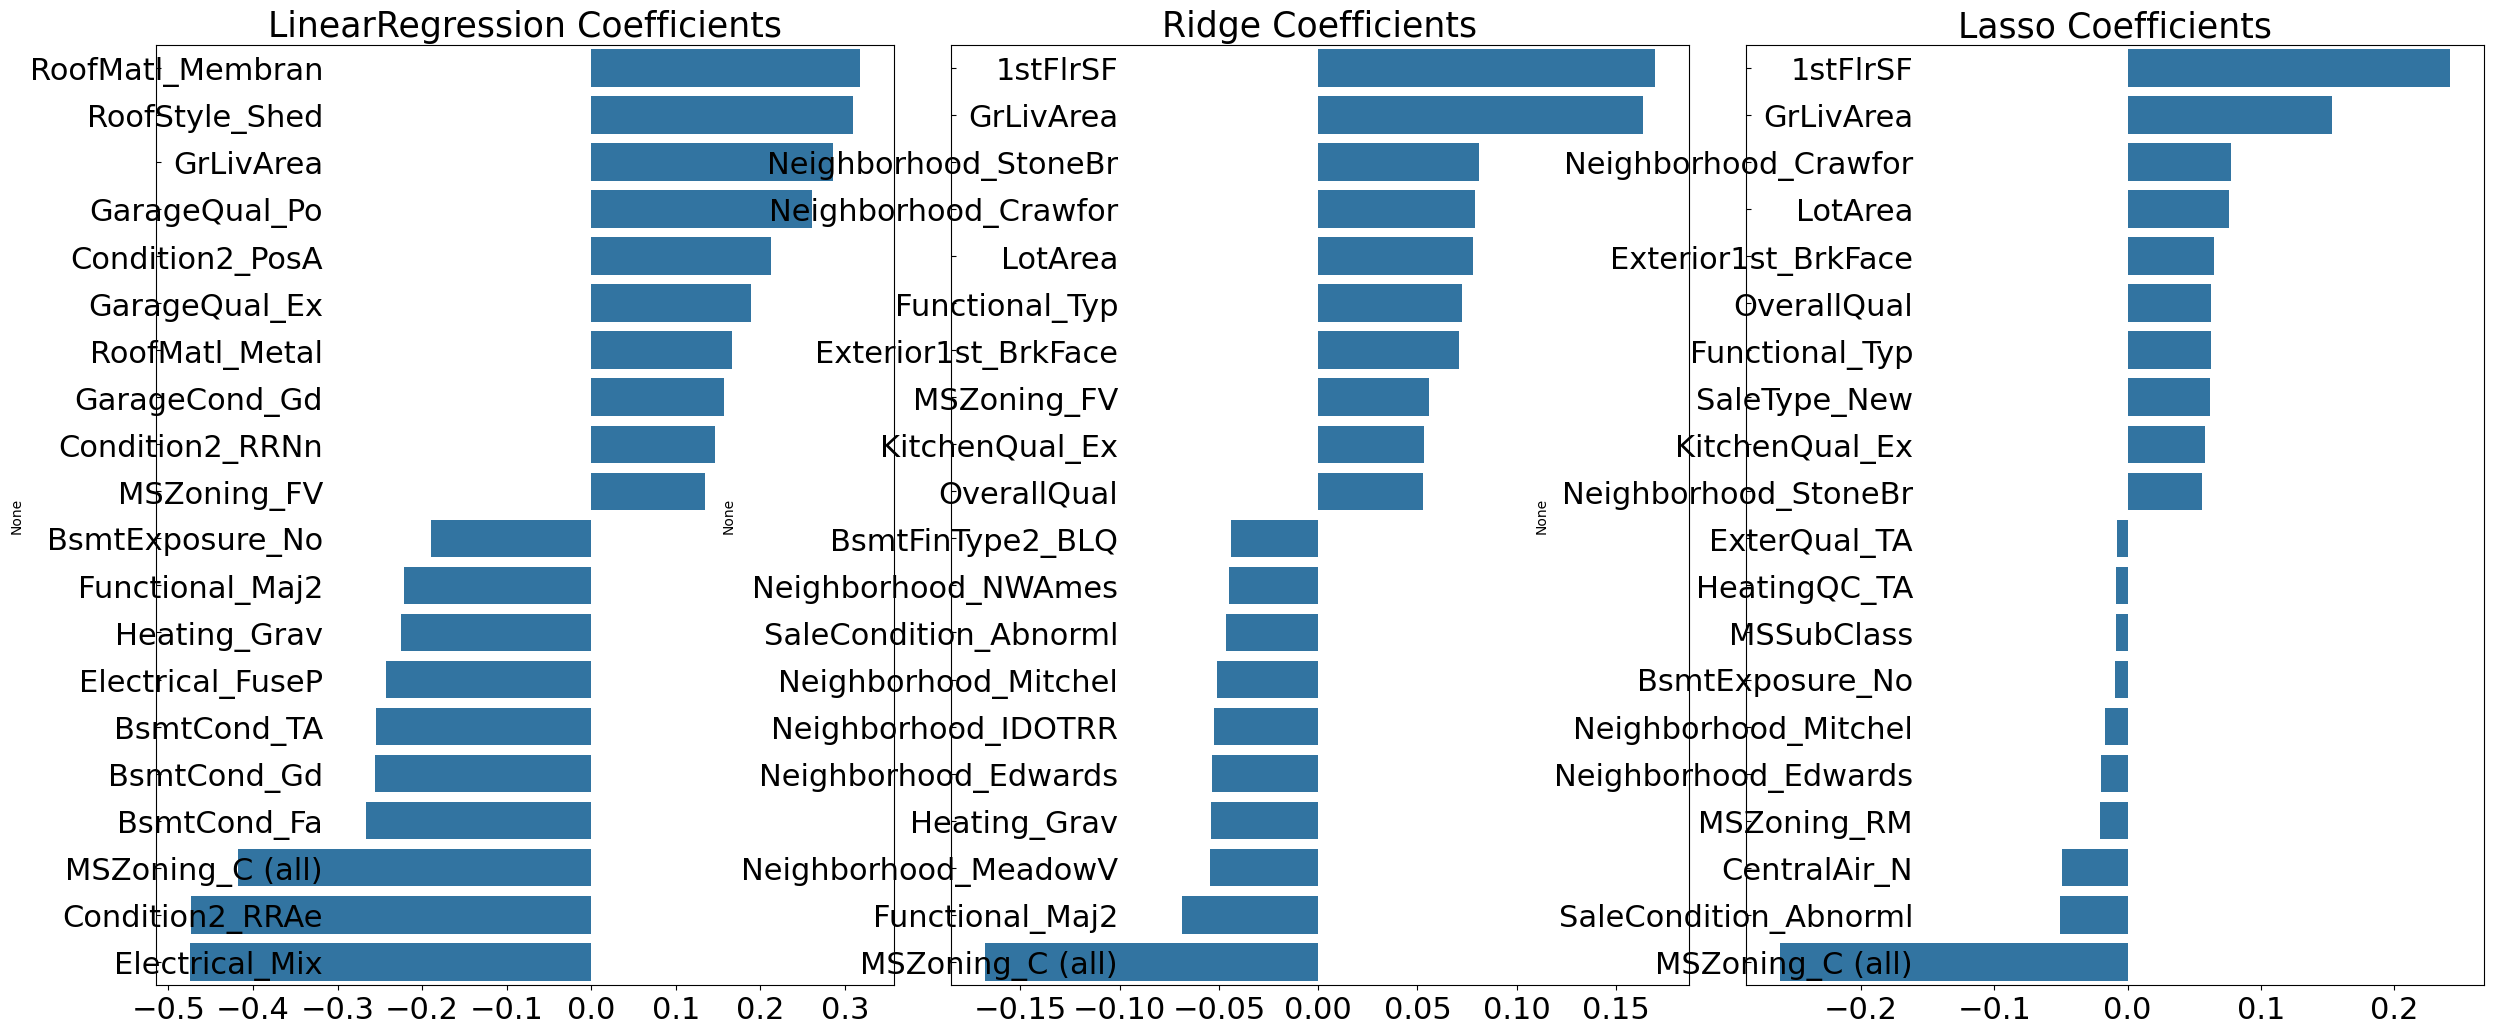

In [340]:
# 앞의 최적화 alpha 값으로 데이터 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

#### 회귀 트리 모델 학습/예측/평가

In [341]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators': [1000]}
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    colsample_bytree=0.5,
    subsample=0.8
    )
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:0.1202, 최적 alpha:{'n_estimators': 1000}


In [342]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators': [1000]}
lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=4,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=10,
    n_jobs=-1
)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3155
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 171
[LightGBM] [Info] Start training from score 12.021352
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3167
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 168
[LightGBM] [Info] Start training from score 12.023516
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of 

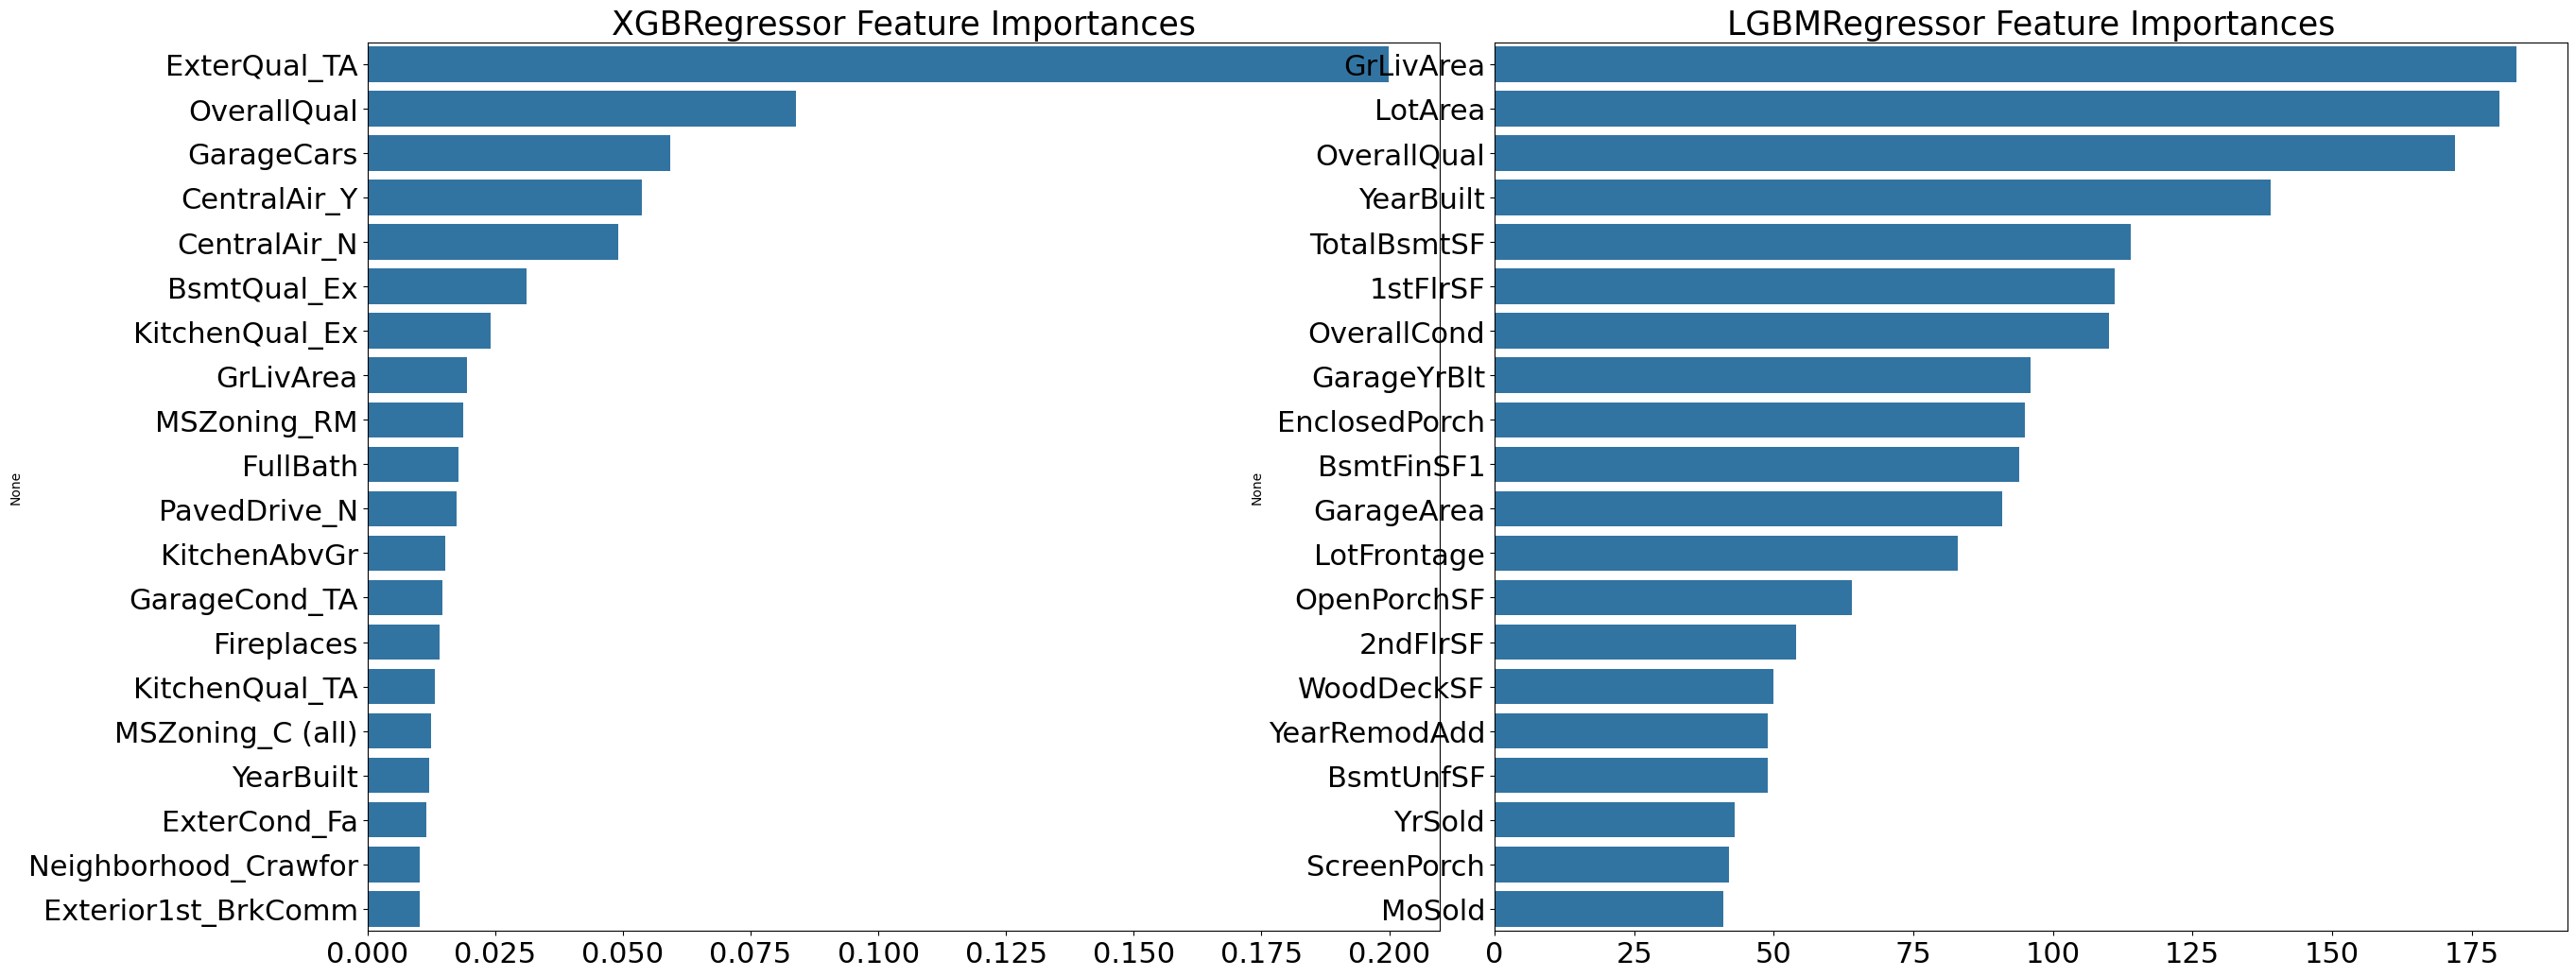

In [343]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

#### 회귀 모델의 예측 결과 혼합을 통한 최종 예측

In [344]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print(f'{key} 모델의 RMSE: {rmse}')

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

# 최종 혼합 모델, 개별 모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.10006075517615198
Ridge 모델의 RMSE: 0.10340697165289389
Lasso 모델의 RMSE: 0.10024171179335334


In [345]:
xgb_reg = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    colsample_bytree=0.5,
    subsample=0.8
    )
lgbm_reg = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=4,
    subsample=0.6,
    colsample_bytree=0.4,
    reg_lambda=10,
    n_jobs=-1
    )
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {
    '최종 혼합': pred,
    'XGBM': xgb_pred,
    'LGBM': lgbm_pred
}

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3174
[LightGBM] [Info] Number of data points in the train set: 1166, number of used features: 172
[LightGBM] [Info] Start training from score 12.025343
최종 혼합 모델의 RMSE: 0.10041298529356603
XGBM 모델의 RMSE: 0.10391120208777559
LGBM 모델의 RMSE: 0.10363891833477148


In [346]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(f'{model.__class__.__name__} model 시작')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        # 입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 세트 추출
        print(f'\t폴드 세트: {folder_counter} 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        # 폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr, y_tr)
        # 폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        # 입력된 원본 테스트 데이터를 폴드 세트 내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)
    
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)
    
    # train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred, test_pred_mean

In [347]:
# get_stacking_base_datasets()는 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base) 모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
Lasso model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
XGBRegressor model 시작
	폴드 세트: 0 시작
	폴드 세트: 1 시작
	폴드 세트: 2 시작
	폴드 세트: 3 시작
	폴드 세트: 4 시작
LGBMRegressor model 시작
	폴드 세트: 0 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 156
[LightGBM] [Info] Start training from score 12.035561
	폴드 세트: 1 시작
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2951
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 162
[LightGBM] [Info] Start training from score 12.022847
	폴드 세트: 2 시작
[LightG

In [348]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 스태킹 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

# 개별 모델 예측값을 기반으로 새롭게 만들어진 학습/테스트 데이터로 메타 모델 예측 및 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print(f'스태킹 회귀 모델의 최종 RMSE 값은: {rmse}')

스태킹 회귀 모델의 최종 RMSE 값은: 0.09694602145235619
